# Predicting Athletes' Success based on Physical Built - Modeling

In [1]:
from ibm_botocore.client import Config
import ibm_boto3

In [2]:
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)
from numpy import loadtxt

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split
from sklearn.model_selection import cross_val_score

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# PySpark
!pip install pyspark==2.4.5
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import lit
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 217.8 MB 68.4 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 48.0 MB/s eta 0:00:01
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257928 sha256=c8488447266aef4abf69f99515e989320fc1bcf714668690e1137e6876266b6b
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/01/c0/03/1c241c9c482b647d4d99412a98a5c7f87472728ad41ae55e1e
Successfully built pyspark


In [3]:
from pyspark import SparkContext
sc =SparkContext()

22/01/03 14:15:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Data

In [4]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.ap.cloud-object-storage.appdomain.cloud'
else:
    endpoint_ae9960ddc8814d4c8b5407d633c117e6 = 'https://s3.private.ap.cloud-object-storage.appdomain.cloud'

client_ae9960ddc8814d4c8b5407d633c117e6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='y-i7Ll-_fH7OmwBZU47jYLDcYfCQFgbdSFfHOig9oGAC',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_ae9960ddc8814d4c8b5407d633c117e6)

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,0,1,2,3,4,5,6,7,8,9,...,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254
0,-1.651038,-2.027846,-1.511511,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.717441,0.250291,1.908546,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.922275,1.769049,1.140778,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.922275,-0.604011,-0.953134,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.286657,-1.363390,-0.988033,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()


,0,1,2,3,4,5,6,7,8,9,...,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254
0,0.170869,-0.319243,-0.743743,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.011322,1.199515,0.582401,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.899632,0.629980,0.512604,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.011322,0.724903,0.373010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.628395,0.440136,1.070981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='y_train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)
df_data_3.head()


,Medal
0,0
1,1
2,0
3,0
4,0


In [7]:

body = client_ae9960ddc8814d4c8b5407d633c117e6.get_object(Bucket='ibmadvanceddatasciencecapstone-donotdelete-pr-imkca0ueactk84',Key='y_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_4 = pd.read_csv(body)
df_data_4.head()


,Medal
0,0
1,0
2,1
3,0
4,1


## Logistic Regression

In [8]:
def plot_scores(optimizer):
    param_C = np.array(optimizer.cv_results_['param_C'])
    mean_cv = optimizer.cv_results_['mean_test_score']
    std_cv = optimizer.cv_results_['std_test_score']
    
    temp_1 = mean_cv - std_cv
    temp_2 = mean_cv + std_cv                                             
    
    plt.semilogx(param_C, mean_cv)
    plt.fill_between(np.array(param_C, dtype=float), np.array(temp_1, dtype=float), np.array(temp_2, dtype=float), alpha=0.3)
    plt.show()

In [9]:
param_grid = {'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]}
cv = 5

estimator = LR(solver='liblinear')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv, scoring='recall')
optimizer_zeros.fit(df_data_1,df_data_3)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]},
             scoring='recall')

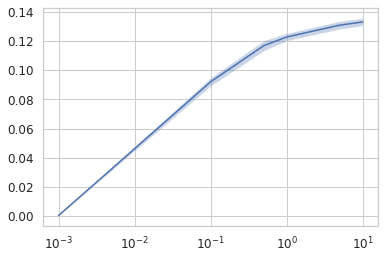

In [10]:
plot_scores(optimizer_zeros)

In [11]:
optimizer_zeros.best_estimator_

LogisticRegression(C=10, solver='liblinear')

In [12]:
roc_auc_score_zeros = roc_auc_score(df_data_4, optimizer_zeros.best_estimator_.predict_proba(df_data_2)[:, 1])
roc_auc_score_zeros

0.782836447654118

In [13]:
optimizer_zeros.best_estimator_


LogisticRegression(C=10, solver='liblinear')

In [14]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, df_data_1, df_data_3, cv=kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

Baseline: 86.03% (0.09%)


## Deep Learning

In [15]:
df_data_1.info

<bound method DataFrame.info of                0         1         2    3    4    5    6    7    8    9  ...  \
0      -1.651038 -2.027846 -1.511511  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1       0.717441  0.250291  1.908546  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
2      -0.922275  1.769049  1.140778  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
3      -0.922275 -0.604011 -0.953134  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
4      -1.286657 -1.363390 -0.988033  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
...          ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
144310 -0.740084  1.199515  1.001184  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
144311  0.899632  0.250291  0.373010  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
144312  0.535250 -1.268467 -1.022931  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   
144313 -0.193512  0.060446 -0.115569  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...   
144314 -1.104466 -0.224321 -0.255164  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...   

       

In [16]:
df_data_3.info

<bound method DataFrame.info of         Medal
0           0
1           1
2           0
3           0
4           0
...       ...
144310      0
144311      1
144312      0
144313      0
144314      0

[144315 rows x 1 columns]>

In [17]:
model = Sequential()
model.add(Dense(16, input_dim=1255, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(df_data_1, df_data_3, epochs=10, batch_size=64)

Epoch 1/10
2255/2255 [==============================] - 14s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8526
Epoch 2/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8527
Epoch 3/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8536
Epoch 4/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8544
Epoch 5/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8530
Epoch 6/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8539
Epoch 7/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8539
Epoch 8/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8542
Epoch 9/10
2255/2255 [==============================] - 13s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8536
Epoch 10/10
2255/2255 [==============

In [19]:
model.evaluate(df_data_2, df_data_4)

1933/1933 [==============================] - 4s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8536


[0.0, 0.853613555431366]